# Lab 2

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [1]:
#Set global variables
#Variables for file and school informaiton

YEARS = ['2014', '2015', '2016', '2017']

#Number of features we will be selecting for feature selection

N_FEATURES_OPTIONS = [25,50,100,"all"]

#Alpha and C we will be using for our classifiers

C_ESTIMATORS = [50, 100, 200, 500]
C_DEPTH = [2, 3, 5]
LEARNING_RATE = [1e-2, 1e-1, 1e0]

#Used for KNN gridsearch
C_NEIGHBORS = [4, 5]

#Used for SVC grid search
C_OPTIONS = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

#Import data all necessary libraries we will be using in our estimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random


from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

%%html
<style>
table {float:left}
</style>

# 1.a Data Preparation
10 points - Deﬁne and prepare your class variables. Use proper variable 
representations (int, ﬂoat, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for 
the analysis.

# The Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools
Our data set originates from the North Carolina Public Schools Reports and Statistics. This public site contains large amounts of information covering many aspects of the performance of students and schools across the state of North Carolina. It includes public and charter schools ranging from the elementary level to high schools. http://www.ncpublicschools.org/

The data used in our lab consists of portions of this data which includes the school years 2014-2017. The data used is the result of combining and cleaning the raw data sets available on the North Carolina website. The machine learning data sets are broken down by school year and then sub-setted by elementary school, middle school and high school information. 

In this lab our data set consists of all the data available for school years 2015-2017 from the Machine Learning data available.  First step is to combine all the data from previous years and add the variable ‘Year’ to each row, keeping track of which year this data was collected.

Next the each feature is inspected for NA values.  If more than 75% of the feature contains NA, we replace that field with 0.  If less than 75% is NA, then the median value of the column is used to replace the NA.

Two binary classifications are performed.  The first is classifiying if a schools average SAT score will be above 1000.  This information is useful to teachers and guidance counselors as they are helping students navigate college searches.  The second classifier examines crime rate as compared to the LEA each school is in.



|<p align="">Variable|<p align="">Type|<p align="">Note|
|--------|----|----|
|<p align="">Year|<p align="">Object|<p align="">Tracks year data is from|
|<p align="">local_crime_greater|<p align="">int64|<p align="">1 if crime in school is above LEA average crime, 0 otherwise
|<p align="">X_crime_reduced|<p align="">Data Frame|<p align="">Used in crime reduced scope model, removes racial information from data|
|<p align="">SAT_Score_Above1000|<p align="">int64|<p align="">1 if SAT score is above 1000 ,0 otherwise.
<BR>
    
Additional features we deem important: 

<img src="files/data_meaning.jpg"> 

# 1.b Data Preparation
5 points - Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [2]:
# All years of the High School Public Schools Machine Learning 
# Date Set is being used throughout this 
# analysis. 
# Load Full Public School Data Frames for each year

school_data = pd.DataFrame()

for year in YEARS:
    #Load public school master file
    temp_year = pd.read_csv('../Data/'+str(year)+'/Machine Learning Datasets/PublicHighSchools'+str(year)+'_ML.csv', low_memory=False)
        
    #Add year column and concatonating all data together
    temp_year['Year']=year
    
    if(school_data.empty):
        school_data = pd.concat([school_data,temp_year],ignore_index=True)
    else:
        school_data = pd.concat([school_data,temp_year], join = "inner",ignore_index=True)


### Impute any missing values

Here we are setting the master dataset that we will be taking a subset of the data for the rest of the paper. This dataset is made up of the 4 years of high school data available from 2014 until 2017, which were combined to a single DataFrame. An inner join was performed to that only columns of data that were present in all imported spreadsheets were kept in the final DataFrame.

A column was added to the data to note which year the data came from. Many of the same schools will be represented multiple times through the years. 

In [3]:
#This is the critical threshold
CRITICAL_NA = .75

#With this we check if the column is less than 75% non-NA, if it is greater than 75% non-NA
#We replace the NA with the median of the column, otherwise we replace the value with 0

imputed_school_data = school_data.apply(lambda col: col.fillna(0) if col.count()/col.shape[0]<CRITICAL_NA else col.fillna(col.median()),axis=0)


#Print the shape and basic statistics for school_data
print(imputed_school_data.shape)
imputed_school_data.describe()


#This is the master data set! 

(1904, 288)


,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,grade_range_cd_PK-12,"calendar_type_txt_Regular School, Year-Round Calendar",esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,unit_code
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,849.853466,830.111870,828.354517,18.629727,19.313550,18.243172,9093.345021,0.670409,0.081126,0.081555,...,0.006828,0.019433,0.034664,0.398109,0.340336,0.398109,0.087185,0.333508,0.309349,510742.404937
std,588.307262,357.643945,105.106371,5.607309,5.510312,5.544849,1204.493613,0.095046,0.016536,0.015932,...,0.082369,0.138077,0.182975,0.489637,0.473947,0.489637,0.282180,0.471590,0.462347,279912.990415
min,8.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10303.000000
25%,326.500000,584.500000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.071000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,280330.000000
50%,783.500000,810.000000,848.000000,19.000000,20.000000,19.000000,8820.080000,0.626000,0.080500,0.081000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,490380.000000
75%,1221.250000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.091000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,761304.000000
max,2966.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,995330.000000


In [4]:
imputed_school_data.sample(5)

,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,"calendar_type_txt_Regular School, Year-Round Calendar",esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,unit_code,Year
43,1379.0,984.0,837.0,27.0,25.0,30.0,7423.42,0.611,0.065,0.100,...,0,0,0,1,0,0,1,0,130307,2014
1119,859.0,647.0,860.0,17.0,21.0,20.0,9205.34,0.611,0.081,0.081,...,0,0,1,1,0,0,0,0,350308,2016
7,1584.0,1584.0,837.0,18.0,18.0,16.0,8251.49,0.614,0.059,0.093,...,0,0,1,1,0,0,0,0,20302,2014
579,231.0,957.0,848.0,21.0,26.0,15.0,8405.83,0.648,0.061,0.063,...,0,0,1,0,0,0,1,0,260347,2015
1527,453.0,484.0,853.0,14.0,28.0,15.0,9910.83,0.820,0.078,0.086,...,0,0,0,0,1,0,1,0,240380,2017


### Get the types of the features in the data frame
We want to see the data type of each column of the original school dataset. Depending on whether we feel the 

In [5]:
imputed_school_data.info()
print('\n')
print(imputed_school_data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 288 entries, student_num to Year
dtypes: float64(266), int64(21), object(1)
memory usage: 4.2+ MB


student_num                                              float64
lea_avg_student_num                                      float64
st_avg_student_num                                       float64
Biology_Size                                             float64
English II_Size                                          float64
Math I_Size                                              float64
lea_total_expense_num                                    float64
lea_salary_expense_pct                                   float64
lea_services_expense_pct                                 float64
lea_supplies_expense_pct                                 float64
lea_instruct_equip_exp_pct                               float64
lea_federal_perpupil_num                                 float64
lea_local_perpupil_num               

In [6]:
# Set unit_code to string. We don't want this to be manipulated as a number
# Rather we want to ensure this is taken as a categorical variable
imputed_school_data['unit_code']=imputed_school_data['unit_code'].astype(str)

In [7]:
# Setting all columns that should be an integer to 
for column in imputed_school_data:
    if imputed_school_data[column].dtype == 'float':
        if np.array_equal(imputed_school_data[column], imputed_school_data[column].astype(int)):
            imputed_school_data[column] = imputed_school_data[column].astype(int)

In [8]:
imputed_school_data.info()
print('\n')
print(imputed_school_data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 288 entries, student_num to Year
dtypes: float64(252), int32(14), int64(20), object(2)
memory usage: 4.1+ MB


student_num                                                int32
lea_avg_student_num                                        int32
st_avg_student_num                                         int32
Biology_Size                                               int32
English II_Size                                            int32
Math I_Size                                                int32
lea_total_expense_num                                    float64
lea_salary_expense_pct                                   float64
lea_services_expense_pct                                 float64
lea_supplies_expense_pct                                 float64
lea_instruct_equip_exp_pct                               float64
lea_federal_perpupil_num                                 float64
lea_local_perpupil_num    

In [9]:
# SAT: adding variables: 

SAT_school_data = imputed_school_data.copy()

SAT_school_data['SAT_Score_Above1000'] = SAT_school_data.apply(lambda each_row: 1 if (each_row['sat_avg_score_num']) > 999 else 0,axis=1)
SAT_school_data['SAT_participation_number'] = SAT_school_data.apply(lambda each_row: (each_row['sat_participation_pct'])*(each_row['student_num']) ,axis=1)
#SAT_school_data['Student_Num_College_Ready_SAT'] = SAT_school_data.apply(lambda each_row: (each_row['SAT_participation_number']) if (each_row['SAT_Score_Above1000'] == 1) else 0,axis=1)

SAT_school_data.describe()




,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,"calendar_type_txt_Regular School, Year-Round Calendar",esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,SAT_Score_Above1000,SAT_participation_number
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,849.853466,830.111870,828.354517,18.629727,19.313550,18.243172,9093.345021,0.670409,0.081126,0.081555,...,0.019433,0.034664,0.398109,0.340336,0.398109,0.087185,0.333508,0.309349,0.435399,411.521127
std,588.307262,357.643945,105.106371,5.607309,5.510312,5.544849,1204.493613,0.095046,0.016536,0.015932,...,0.138077,0.182975,0.489637,0.473947,0.489637,0.282180,0.471590,0.462347,0.495939,379.676251
min,8.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326.500000,584.500000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.071000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,133.605000
50%,783.500000,810.000000,848.000000,19.000000,20.000000,19.000000,8820.080000,0.626000,0.080500,0.081000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,314.703500
75%,1221.250000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.091000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,565.942500
max,2966.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2358.030000


# Get highly correlated features

We are creating a matrix listing all of the variables with greater than 90% correlation.

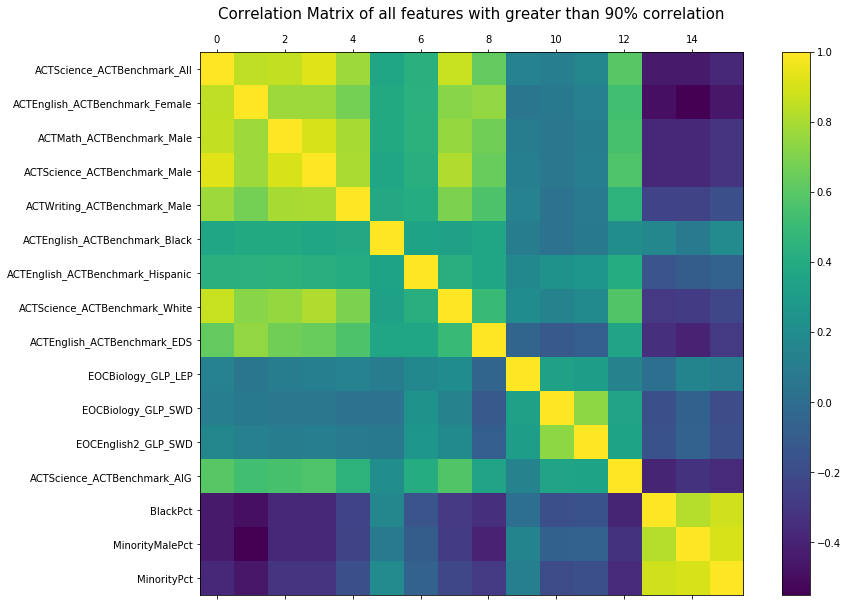

In [10]:
corr_matrix = imputed_school_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
highly_correlated = [column for column in upper.columns if any(upper[column] > 0.90)]


fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Correlation Matrix of all features with greater than 90% correlation',
            fontdict={'fontsize': 15})

cax = ax.matshow(imputed_school_data[highly_correlated].corr());
ax.set_yticklabels(highly_correlated);
ax.set_yticks(np.arange(0, len(highly_correlated), 1.0))
fig.colorbar(cax)
plt.show()

# 2.a Evaluation Metrics
Using the right evaluation metric for classification system is crucial. Otherwise, it may results in thinking that the model is performing well but in reality, it doesn’t.

There are two tasks in this section of “NC Educational Data” project:

The first task is to predict a binary classification target, either if the average SAT score of each school is good enough to gets the student to North Carolina Universities or not. The SAT is a standardized test widely used for college admissions in the United States. For this purpose we have a cut off 1000 out of 1600. The second task is to predict if the crime per 100 students at each school level is higher than the LEA level or not. After considering all evaluation metrics for classification systems, we ended up using ROC Curve. Area under ROC Curve (or AUC for short) is a performance metric for binary classification problems.

In fact, a ROC curve can be used to select a threshold for a classifier which maximizes the true positives, while minimizing the false positives.

We usually use ROC when both classes detection are important. Here, our models should be able to decrease both false positive rate (which is identifying the schools with enough good average SAT score for getting admission in different universities) and also decreasing the false negative rate (which is detecting schools with not good average SAT scores).

The same for the second task, it is important to decrease both false positive and false negative rates.

The AUC represents a model’s ability to discriminate between positive and negative classes. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model as good as random. Most classifiers have AUCs that fall somewhere between these two values. Therefore, the overall model performances can be compared by considering the AUC.

# 2.b Modeling and Evaluation
Two different data frames based on the same data are used for SAT classification and crime classification. Each data frame is initially split into a training and a test data set. We set aside 20% of the complete data set to test against.  During the training of the model, a standard 10 fold cross validation technique, which. We chose to shuffle the data during the cross validation to provide a higher confidence there was no grouping of schools that we did not notice.

Other options available are the Stratifeid k-fold technique which works to balance the ratio of labels used in each fold.  Our dependent variable (local_crime_greater) has approximately a 45-55% split (see pie chart below), and with a large enough data set we can have a high level of confidence of a random split in the data without using Stratfied techniques.  The same held true for the SAT score where the split was approximately 56%-44% (see pie chart below) 

We chose a K fold (10 folds) validation algorithm, however a  Shuffle Split may have performed just as well with this size data set. Where Shuffle Split is capable of creating n folds and fitting the data using n-1 to train and 1 to test against, there is a chance the same data will appear in the test set each time the data is sampled. We chos K fold to insure each value is used in the training set.


We chose not use the Leave One Out (LOO) cross validation due to the computational cost on data set as complex as this.  Empirical evidence has shown a 10-fold cross validation is preferred to the LOO algorithm

Grouping algorithms were not relevant to our data set as we do not have groups of dependent variables.

(soure:http://scikit-learn.org/stable/modules/cross_validation.html)


# Task 1: Crime - Classification Model

In [11]:
# split X and y into test and train sets. We still want
# to do this for external Cross Validation

crime_imputed_school_data = imputed_school_data

crime_imputed_school_data['local_crime_greater'] = crime_imputed_school_data.apply(lambda each_row: 0 if (each_row['crime_per_c_num']-each_row['lea_crime_per_c_num'])<0 else 1,axis=1)

#split data into X and y dataframes

y_crime = crime_imputed_school_data['local_crime_greater']

#Removed SPG Grade and unit code(which is primary key for school data table)
 
X_crime = crime_imputed_school_data[crime_imputed_school_data.columns.drop(list(crime_imputed_school_data.filter(regex='crime|lea|LEA|^st\_')))]

X_crime_train, X_crime_test, y_crime_train, y_crime_test = train_test_split(X_crime, y_crime, test_size=.2)
y_crime.dtype

dtype('int64')

45.59% of the schools have local crime higher then their local LEA average in the training set


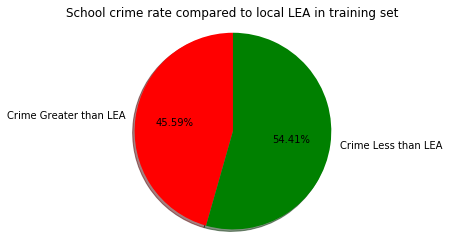

In [12]:
print ('{0:.2%} of the schools have local crime higher then their local LEA average in the training set'.format(y_crime.sum()/len(y_crime)))
labels = 'Crime Greater than LEA', 'Crime Less than LEA',
scores = [(y_crime.sum()/len(y_crime)), 1-(y_crime.sum()/len(y_crime))]
colors = ['red','green']
 
# Plot
plt.pie(scores, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)
 
plt.axis('equal')
plt.title('School crime rate compared to local LEA in training set')
plt.show()

# Task 2: SAT Score - Classification Model

In [13]:
# To split X and y into test and train sets.

y_SAT = SAT_school_data['SAT_Score_Above1000']

#Removed SAT_SCore_above1000 and unit code(which is primary key for school data table)
 
X_SAT = SAT_school_data[SAT_school_data.columns.drop(list(SAT_school_data.filter(regex='SAT_Score|SAT_score|SAT_SCORE|sat_avg|unit_code|lea|LEA|^st\_')))]



43.54% of the schools have SAT scores above 1000 in the training set


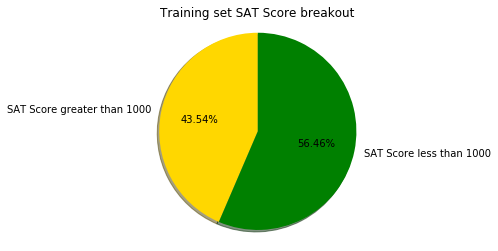

In [14]:
X_SAT_train, X_SAT_test, y_SAT_train, y_SAT_test = train_test_split(X_SAT, y_SAT, test_size=.2)
print ('{0:.2%} of the schools have SAT scores above 1000 in the training set'.format(y_SAT.sum()/len(y_SAT)))
y_SAT.dtype
labels = 'SAT Score greater than 1000', 'SAT Score less than 1000',
scores = [(y_SAT.sum()/len(y_SAT)), 1-(y_SAT.sum()/len(y_SAT))]
colors = ['gold','green']
 
# Plot
plt.pie(scores, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)
plt.title('Training set SAT Score breakout')
 
plt.axis('equal')
plt.show()

# 2.c Modeling and Evaluation
20 points - Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.

We are establishing a basic pipeline that will run our data through three basic steps:
1. Dimentionality Reduction
2. Observation Scaling
3. Model Classification

For steps 1 and 2 we are using the same steps for all models, as we want to focus on the effectiveness of each classification algorithm. First, we will be using the SelectKBest algorithm, which will select the top number of variables from the features, this will be determined through cross-validation. Next the results will be fed into the standardscaler step, which will scale our variables. This improves our prediction outcomes and makes later feature interpretation significantly easier, since all coefficients will be on the same scale.

For all models that take a random state seed, we will be using the same random seed of 123. We want to eliminate the variability of getting different results between running our models so that we are able to hold which model is going to be the best model, for later interpretation. 

In [16]:
k_fold = KFold(n_splits=10,shuffle=True)

#This creates the template for the pipeline
# This creates a basic pipeline where we will 
# test for dementionality reduction, scaling,
# and classification.


pipe = Pipeline([ ('reduce_dim',SelectKBest(chi2)),
                  ('scale', StandardScaler()), 
                  ('clf', GradientBoostingClassifier())])

# SAT Models
For the SAT model we tried 5 different algorithms to create a model which has superior prediction capabilities based on the ROC/AUC scoring parameter:
* K-Nearest Neighbor
* SVM
* Random Forest Classification

We created a ROC/AUC plot for each model and summarized our findings based on the combined results for these different models.

# SAT Model #1 : Random Forest Classifier

In [17]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
         'clf__random_state':[123]
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )

SAT_RandomForest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score1 = grid_search.predict(X_SAT_test)
y_SAT_prob1=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob1[:,1]))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.3min finished


0.9264050961159027


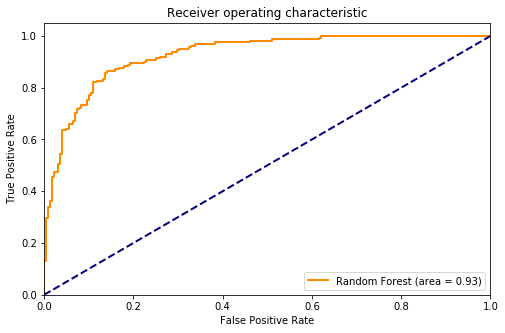

In [18]:
# create ROC cuve for Random Forest model:
fpr1, tpr1, _ = roc_curve(y_SAT_test, y_SAT_prob1[:,1] )
roc_auc1 = auc(fpr1, tpr1)
lw=2

plt.figure(figsize=(8,5));
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# SAT Model #2 : KNN Classifier

In [20]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [KNeighborsClassifier()],
         'clf__n_neighbors': C_NEIGHBORS,
         
    }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=k_fold,n_jobs=-1, verbose=1 )

SAT_KNearest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score2 = grid_search.predict(X_SAT_test)

y_SAT_prob2=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob2[:,1]))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.5s finished


0.8378008906928238


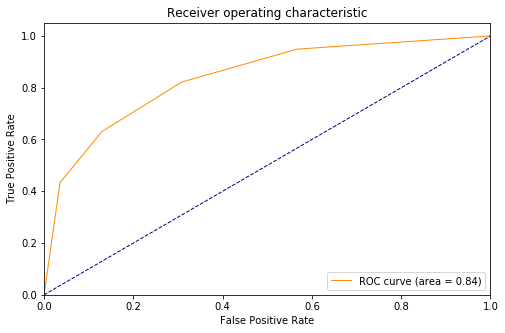

In [22]:
# Plot ROC Curve
fpr2, tpr2, _ = roc_curve(y_SAT_test, y_SAT_prob2[:,1] )
roc_auc2 = auc(fpr2, tpr2)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# SAT Model #3 :  SVC Classifier

In [23]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [SVC(probability=True)],
         'clf__C': C_OPTIONS,
         'clf__random_state':[123]
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )

SAT_SVC_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score3 = grid_search.predict(X_SAT_test)
y_SAT_prob3=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob3[:,1]))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.1s finished


0.9234247042766152


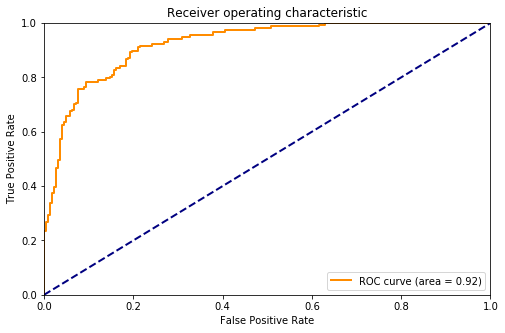

In [24]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr3, tpr3, _ = roc_curve(y_SAT_test, y_SAT_prob3[:,1] )
roc_auc3 = auc(fpr3, tpr3)
lw=2

plt.figure(figsize=(8,5));
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Crime Models
For the crime model we tried 5 different algorithms to create a model which has superior prediction capabilities based on the ROC/AUC scoring parameter:
* Logistic Regression
* Feature Bagging
* Gradient Boosting
* ADA Boosting
* Random Forest Classification

We created a ROC/AUC plot for each model and summarized our findings based on the combined results for these different models.

# Crime Model #1: Gradient Boosting

In [25]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf':[GradientBoostingClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
         'clf__learning_rate':LEARNING_RATE,
         'clf__random_state':[123]
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_GradientBoost_model = grid_search.fit(X_crime_train, y_crime_train)


y_crime_GradientBoost_score = grid_search.predict(X_crime_test)
y_crime_GradientBoost_prob = grid_search.predict_proba(X_crime_test)
print(roc_auc_score(y_crime_test, y_crime_GradientBoost_prob[:,1]))


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  9.0min finished


0.7823588205897052


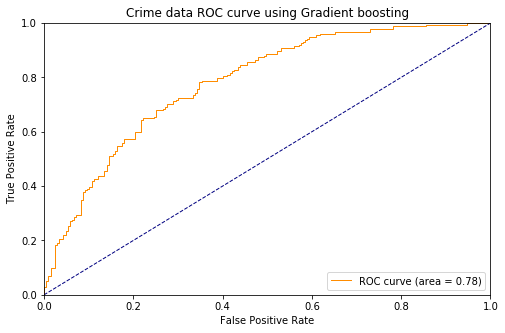

In [26]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_GradientBoost_prob[:,1])
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using Gradient boosting')
plt.legend(loc="lower right")
plt.show()

# Crime Model #2: ADA Boost

In [27]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [AdaBoostClassifier()],
         'clf__n_estimators': C_ESTIMATORS,
         'clf__learning_rate':LEARNING_RATE,
         'clf__random_state':[123]
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_ADABoost_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_ADABoost_score = grid_search.predict(X_crime_test)
y_crime_ADABoost_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_ADABoost_prob[:,1]))


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   29.9s finished


0.7481102712316585


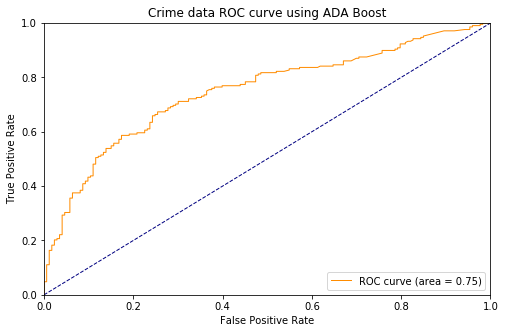

In [28]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_ADABoost_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using ADA Boost')
plt.legend(loc="lower right")
plt.show()

# Crime Model #3: Random Forest Classifier

In [58]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
         'clf__random_state':[123]
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_RandomForest_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_RandomForest_score = grid_search.predict(X_crime_test)
y_crime_RandomForest_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_RandomForest_prob[:,1]))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   12.0s finished


0.7396620720320142


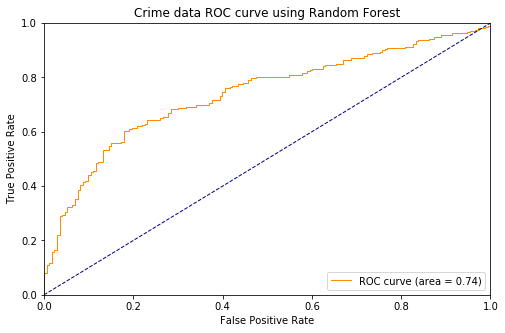

In [31]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_RandomForest_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using Random Forest')
plt.legend(loc="lower right")
plt.show()

# Crime Model #4: Logistic Regression

In [35]:

param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [LogisticRegression()],
         'clf__C': [1e-3,1e-2,1e-1,1e0,1e1,1e2],
         'clf__random_state':[123] 
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_LogicReg_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_LogicReg_score = grid_search.predict(X_crime_test)
y_crime_LogicReg_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_LogicReg_prob[:,1]))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   25.9s finished


0.747542895219057


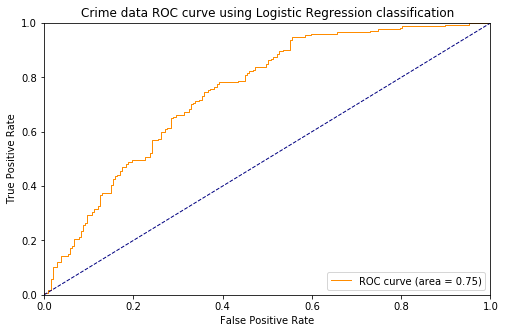

In [36]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_LogicReg_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using Logistic Regression classification')
plt.legend(loc="lower right")
plt.show()

# Crime Model #5: Bagging Method

In [35]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [BaggingClassifier(DecisionTreeClassifier())],
         'clf__n_estimators': C_ESTIMATORS,
         'clf__random_state':[123] 
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_Bagging_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_Bagging_score = grid_search.predict(X_crime_test)
y_crime_Bagging_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_Bagging_prob[:,1]))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.2min finished


0.7738995108937305


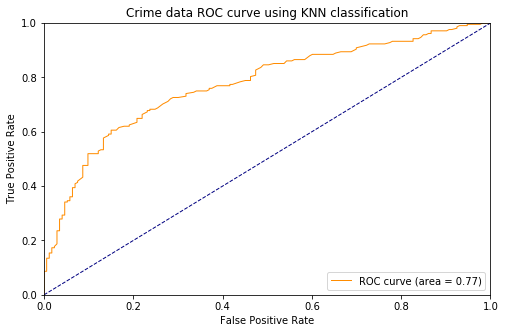

In [36]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_Bagging_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using KNN classification')
plt.legend(loc="lower right")
plt.show()

## Crime ROC Model comparison
When we plot all ROC curves on the same chart we can see some evidence that all models are providing the same type of results.  The ADA Boost Classifier appears to have a slightly better rate of True Positive vs False Positive classification

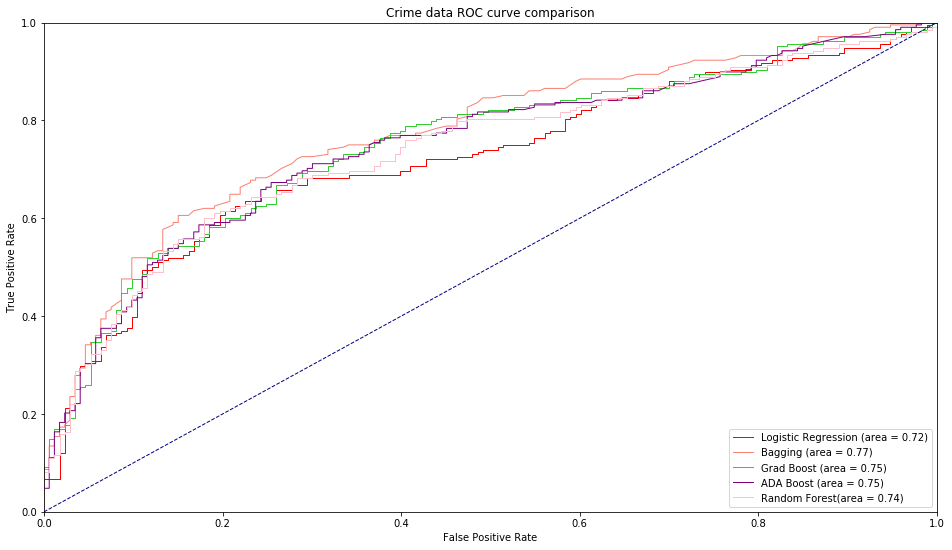

In [37]:
# Plot ROC Curve
fpr1, tpr1, _ = roc_curve(y_crime_test, y_crime_LogicReg_prob[:,1] )
fpr2, tpr2, _ = roc_curve(y_crime_test, y_crime_Bagging_prob[:,1] )
fpr3, tpr3, _ = roc_curve(y_crime_test, y_crime_GradientBoost_prob[:,1])
fpr4, tpr4, _ = roc_curve(y_crime_test, y_crime_ADABoost_prob[:,1])
fpr5, tpr5, _ = roc_curve(y_crime_test, y_crime_RandomForest_prob[:,1])
lw=1

plt.figure(figsize=(16,9));
plt.plot(fpr1, tpr1, color='red', lw=1, label='Logistic Regression (area = %0.2f)' % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, color='salmon', lw=1, label='Bagging (area = %0.2f)' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, color='limegreen', lw=1, label='Grad Boost (area = %0.2f)' % auc(fpr3, tpr3))
plt.plot(fpr4, tpr4, color='purple', lw=1, label='ADA Boost (area = %0.2f)' % auc(fpr4, tpr4))
plt.plot(fpr5, tpr5, color='pink', lw=1, label='Random Forest(area = %0.2f)' % auc(fpr5, tpr5))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve comparison')
plt.legend(loc="lower right")

plt.show()

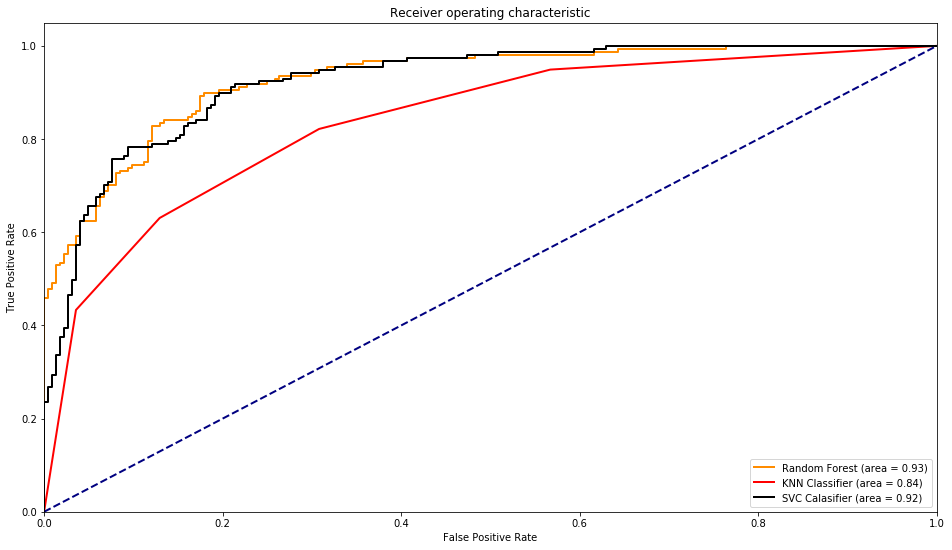

In [38]:
#SAT Models Comparison with ROC curves for all 3 models:
fpr1, tpr1, _ = roc_curve(y_SAT_test, y_SAT_prob1[:,1] )
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _ = roc_curve(y_SAT_test, y_SAT_prob2[:,1] )
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, _ = roc_curve(y_SAT_test, y_SAT_prob3[:,1] )
roc_auc3 = auc(fpr3, tpr3)
lw=2


plt.figure(figsize=(16,9));
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='KNN Classifier (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='black', lw=2, label='SVC Calasifier (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# 2.d Modeling and Evaluation
10 points - Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

# 2.e Modeling and Evaluation
10 points - Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference signiﬁcant with 95% conﬁdence? Use proper statistical comparison methods.

Models we implemented thus far: 

1. K-Nearest Neighbor 

Advantage: 

-Model does not need to be trained and incremental learning is done when new data is fed in. 

Disadvantage: 

-Does not handle large number of dimensions.

-Weighing of attributes needs to be done. Additional work. 

-memory intensive. 

2. SVM

Advantage: 

-Can handle large number of dimensions. 

-Many kernels to choose from. 

-Fairly robust against overfitting. 

Disadvantage:

-Memory intensive and time consuming.

-Parameterization is hard.  


3. Random Forest 

Advantage: 

-Robust to overfitting. 

-Performs well with large number of features.

Disadvantage: 

-learning is slow and integration to improve generated models is not possible. 

4. Logistic Regression 

Advantage: 

-Output is very informative compared to most models. 

-Two important measures: Coefficient size (how relevant) and positive/negative (direction of association)

Disadvantage: 

-Not as flexible as other models. 

-High Bias

-Underperform when non-linear decision boundaries exist. 

5. Feature Bagging 

Advantage: 

-Provides variable importance measure: Gini Index

-Handles categorical features with ease. 

Disadvantage: 

-Visual interpretation is difficult.

-If the features are correlated, does not reduce variance. 

6. Boosting 

Advantage: 

-Good parameterization (easy). 

-Robust to overfitting and performs well with large amounts of data. 

Disadvantage: 

-Training is time consuming and takes a lot of memory depending on the dependence of a weak predictor. 

<img src="files/Model_table.jpg"> 


Citation: 
http://horicky.blogspot.com/2012/02/characteristics-of-machine-learning.html 

https://victorfang.wordpress.com/2011/05/10/advantages-and-disadvantages-of-logistic-regression/

https://www.quora.com/What-are-the-advantages-of-logistic-regression

https://elitedatascience.com/machine-learning-algorithms

https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning

https://recast.ai/blog/machine-learning-algorithms/2/   (Table Citation) 


Statistical Comparison Methods (from BLT 7.5): 
==============

<img src="files/eq2.jpg"> 
<img src="files/eq1.jpg"> 


#in case image doesn't, equations restated: 

o^2=((e(1-e))/n) 

CI= (e1-e2)+-1.96(sqrt(var1^2+var2^2))


SAT Models: 
==============
<BR>
Model 1 - K-Nearest Neighbor 
    
o^2=((e(1-e))/n) 

e= .16

((.16)(1-.16))/1904 = .00007058

Model 2  - SVM 

o^2=((e(1-e))/n) 

e= .08

((.08)(1-.08))/1904 = .00003865

Confidence interval

(.16-.08)+-1.96(sqrt(.00007058+.00003865)) = [0.05951, 0.10048]

Our confidence interval does not contain 0 so we are 95% confident that these two models are not the same.
<BR>


Model 1 - K-Nearest Neighbor 

o^2=((e(1-e))/n) 

e= .16

((.16)(1-.16))/1904 = .00007058

Model 3  - Random Forest  

o^2=((e(1-e))/n) 

e= .07

((.07)(1-.07))/1904 = .00003419

Confidence interval

(.16-.07)+-1.96(sqrt(.00007058+.00003419)) = [0.06993, .11006]

Our confidence interval does not contain 0 so we are 95% confident that these two models are not the same.
<BR>


Model 2  - SVM 

o^2=((e(1-e))/n) 

e= .08

((.08)(1-.08))/1904 = .00003865

Model 3  - Random Forest  

o^2=((e(1-e))/n) 

e= .07

((.07)(1-.07))/1904 = .00003419

Confidence interval

(.08-.07)+-1.96(sqrt(.00003865+.00003419)) = [0.02672, 0.06993]

Our confidence interval does not contain 0 so we are 95% confident that these two models are not the same.
<BR>


Crime Models (Michael): 
==============





# Feature Importance for the Top Performing Model
10 points - Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classiﬁcation task.

We identified Random Forest and Bagging classifiers are the best performing classifiers to differentiate the two classes of SAT scores and Crime in our dataset. In this part, we proceed to find the below information:

- Level of importance of each feature in this model. 
- Select relevant feature (variable) to guarantee best model performances using recursive feature elimination.

Feature selection is a process where you automatically select those features that contribute most to the outcome we are trying to predict. 

Having irrelevant features in the data can decrease the accuracy of the models. Some of the benefits of feature selection include reduce overfitting, improving accuracy and minimizing computing time.

The features that have the biggest impact on the model performance for each of these two models are evaluated.


* All features are scaled in the model.
* The coefficient values indicate the level of feature influence on model performance, higher value means stronger influence and importance.
* The influence values are sorted and top 20 features with strongest influences are plotted.

# Feature Evaluation for the top performing SAT Model: Random Forest Classifier

The list of top 20 features and their level of importance is illustrated in here:

In [51]:
# set the parameters of this estimator and fit the model
pipe.set_params(**SAT_RandomForest_model.best_params_)
pipe.fit(X_SAT_train, y_SAT_train)

coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_SAT_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the features 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 20 features that influence SAT Score are the following")
display(predicted_data.sort_values(by='Influence', ascending=False)[0:20])

The top 20 features that influence SAT Score are the following


,Influence
ACTMath_ACTBenchmark_All,0.056014
ACTMath_ACTBenchmark_Male,0.044179
ACTScience_ACTBenchmark_All,0.038173
EOCSubjects_CACR_All,0.032436
ACTMath_ACTBenchmark_White,0.030219
ACTScience_ACTBenchmark_Male,0.029690
ACTEnglish_ACTBenchmark_Female,0.029220
ACTSubtests_BenchmarksMet_AIG,0.027249
ACTWriting_ACTBenchmark_All,0.022999
SPG Score,0.022365


The bar charts that visualize the Influence of 20 features with strongest impact on the performance of SAT Random Forest model are also shown here:


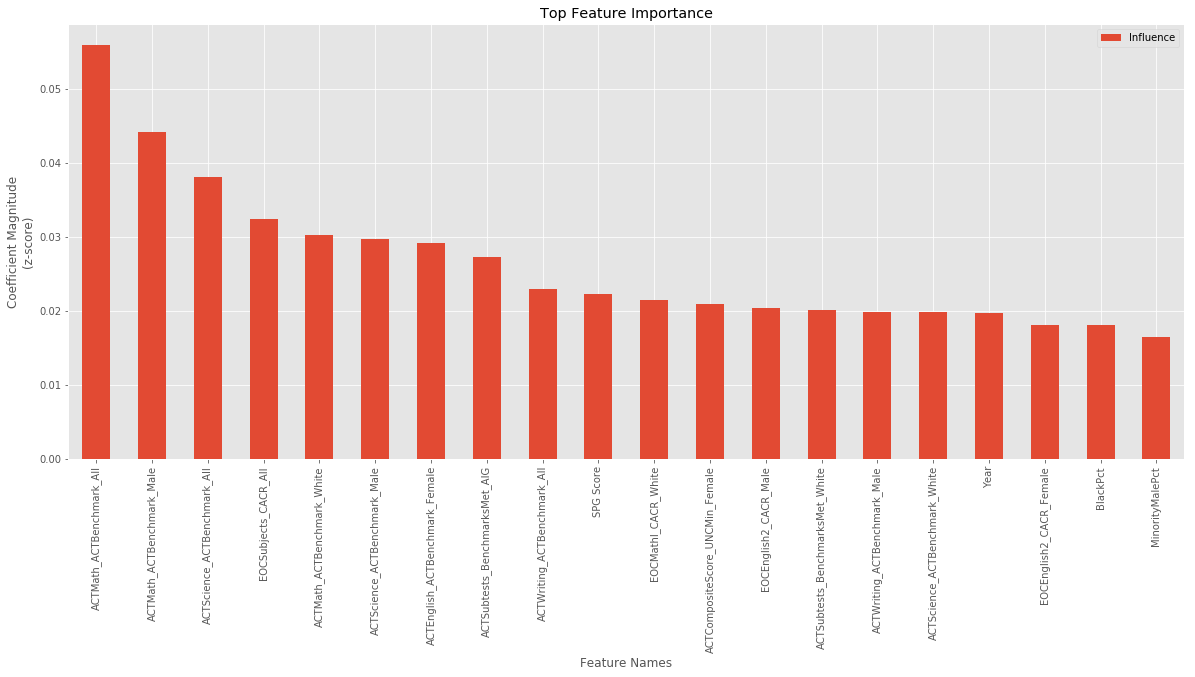

In [50]:
plt.style.use('ggplot')
Importances=predicted_data.sort_values(by='Influence', ascending=False)[0:20]
wt_plt_df = predicted_data.head(75)

weights = pd.Series(wt_plt_df['Influence'].values,index=wt_plt_df.index)
ax = Importances.plot(kind='bar', figsize=(20,8))




ax.set_title("Top Feature Importance")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

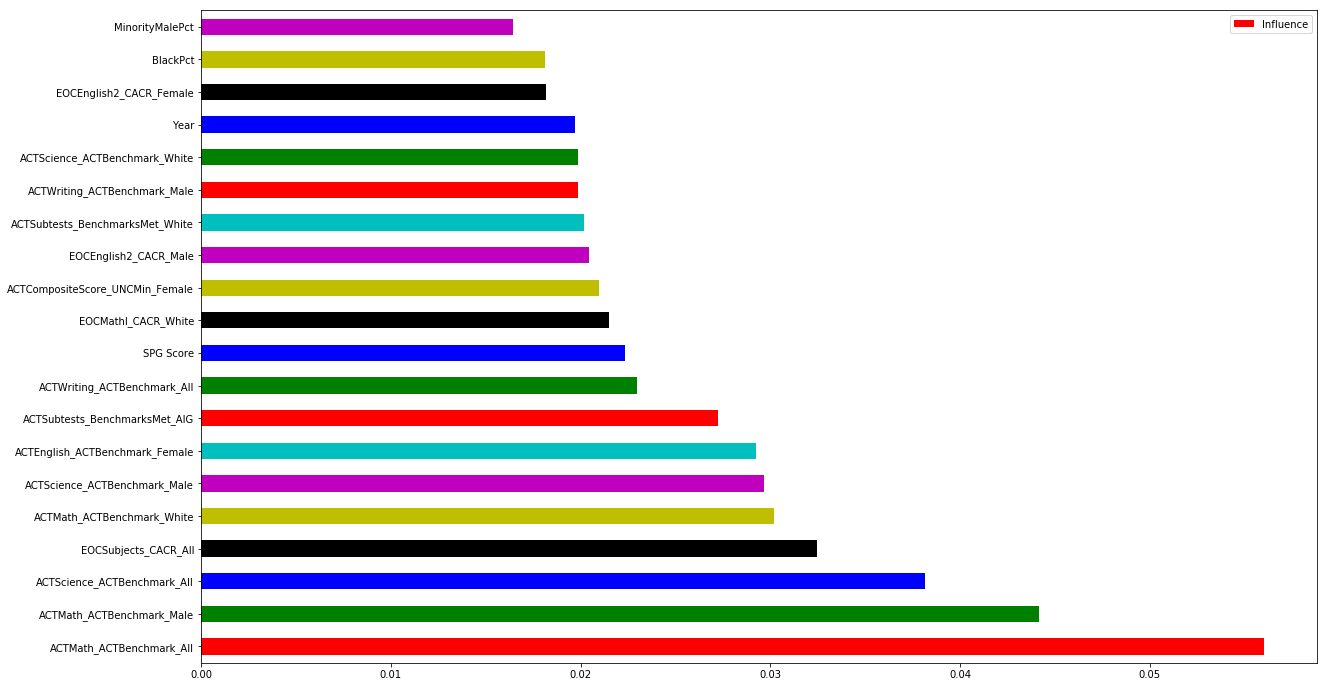

In [23]:
predicted_data.sort_values(by='Influence', ascending=False)[0:20].plot(kind='barh', figsize=(20,12), color='rgbkymc');

By looking at the table and graphs, the most important feature is "ACTMath_ACTBenchmark_All" which has the highest importance value. 

# Recursive Feature Elimination

All of our models in both tasks, already include dimentionality reduction and feature scaler. Therefore, teh models are already use the best parameters and are using the optimal number of features to achieve the best perfomance. 

In this part we perform a different type of feature elimination method just to illustrate the most important features and the accuracy of the test. We also use the same metric, ROC, in this part too.

In [53]:
model = RandomForestClassifier()
model.fit(X_SAT_train, y_SAT_train)
 
# make predictions for test data and evaluate
pred_y = model.predict(X_SAT_test)
predictions = [round(value) for value in pred_y]
accuracy = roc_auc_score(y_SAT_test, predictions)
print("RFC Accuracy: %.2f%%" % (accuracy * 100.0))
 
# fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)[::-1]

top_accuracy=0
accuracy_plot = []

for thresh in thresholds:
      
    # selecting features using threshold
    selection = SelectFromModel(model, threshold=thresh,prefit=True)
    select_train_X = selection.transform(X_SAT_train)

    # training model
    selection_model = RandomForestClassifier(random_state=123, max_depth=5, n_estimators=100)
    selection_model.fit(select_train_X, y_SAT_train)
    
    # evaluating model
    select_test_x = selection.transform(X_SAT_test)
    pred_y = selection_model.predict(select_test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = roc_auc_score(y_SAT_test, predictions)
    #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_x.shape[1], accuracy*100.0))
    if accuracy > top_accuracy:
        top_accuracy = accuracy
    if thresh > 0.000:
        accuracy_plot.append(accuracy)
print(round(top_accuracy,5))


RFC Accuracy: 83.69%
0.8902


As shown in the line chart below, The optimal number of features is around 35 features that result in creating the model with more than 89% of accuracy. 
Using only 35 features give us a less complex model along with the maximum accuracy.


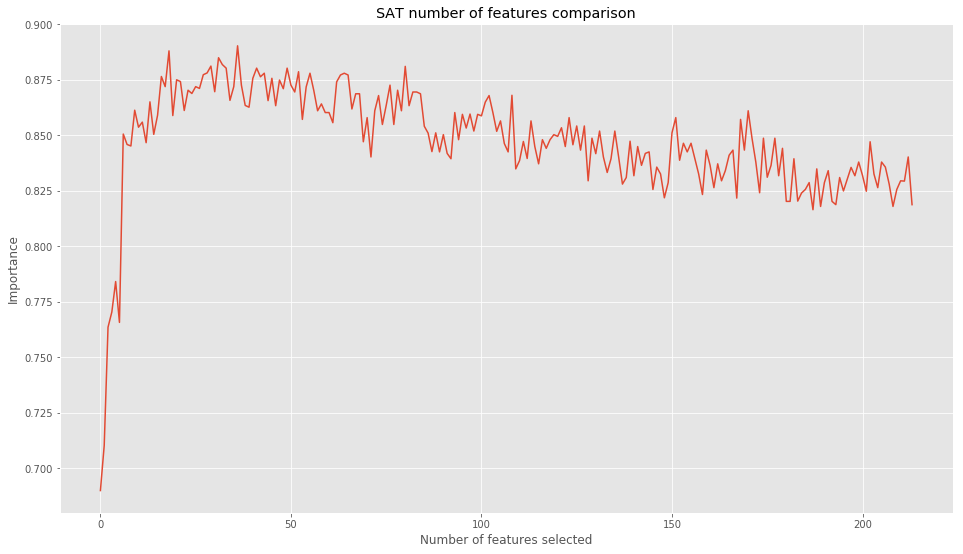

In [54]:
plt.figure(figsize=(16,9));
plt.plot(accuracy_plot);
plt.title('SAT number of features comparison')
plt.xlabel("Number of features selected")
plt.ylabel("Importance")

plt.show()


#  Feature Evaluation for the top Performing Crime Model: Gradient Boost Classifier

The list of top 20 features and their level of importance is illustrated in here:


In [40]:
# set the parameters of this estimator and fit the model
pipe.set_params(**crime_GradientBoost_model.best_params_);
pipe.fit(X_crime_train, y_crime_train)

coef = pipe.steps[2][1].feature_importances_


mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the features
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence improved crime rates for a school are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:20])

The top 10 features that influence improved crime rates for a school are the following


,Influence
avg_daily_attend_pct,0.072433
short_susp_per_c_num,0.026186
cte_courses,0.020879
advance_dgr_pct,0.018660
stud_internet_comp_num,0.016098
long_susp_per_c_num,0.015483
_1yr_tchr_trnovr_pct,0.013173
tchyrs_4thru10_pct,0.013076
GraduationRate_4yr_Male,0.011789
SPG Score,0.011255


The top 20 features are ordered by their importance. Average daily attendance percentage at school level explaines the accuracy of target variable more than other attributes and it counts for around 7% of feature importance. With more attendence percentage at school we observe less crime. 

The next attribute that has the highest importance rank is "short_susp_per_c_num" which is the short term suspensions per 100 students at school level. This short term suspensions are less serious offenses and can last up to ten days. It plays a big role in predicting either the crime at school level is higher or lower than LEA level.

Similarly, the Cte_courses is another feature that has a strong impact on teh performance of the model. It shows the percent of students enrolled in at least one career and technical education (CTE) course at the school level. 

By going down the ranking table provided above, we see obvious relationships between teh feature and the crime response variable.






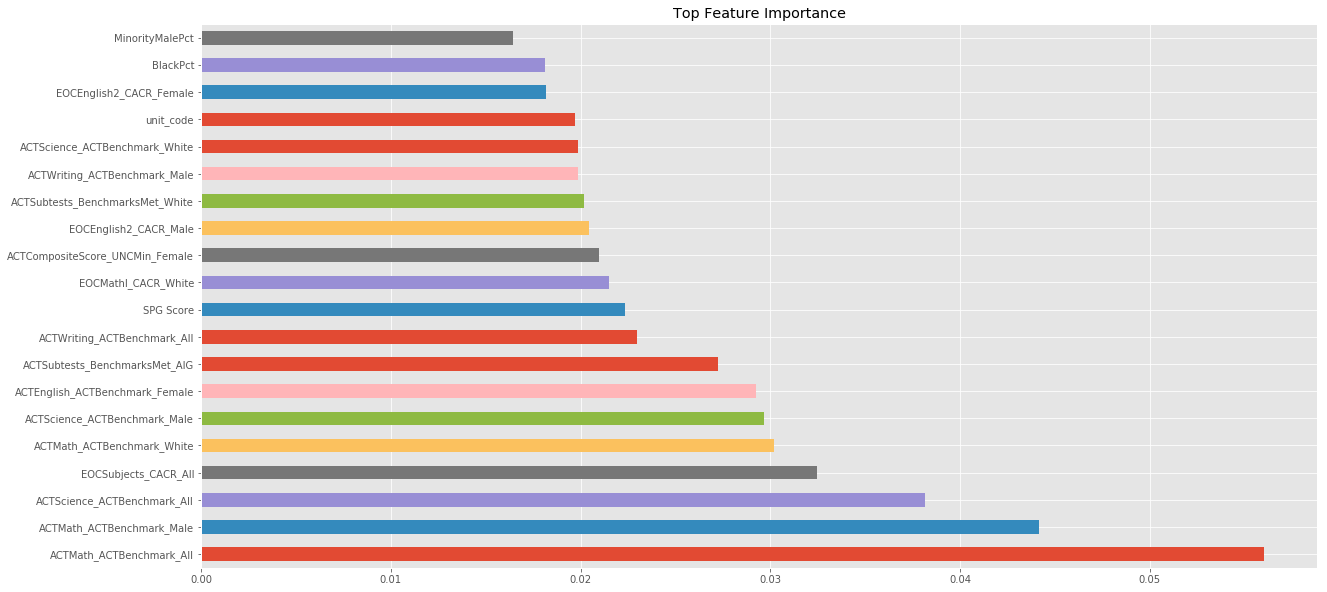

In [56]:
# Crerate the bar chart with the 20 most important features
feat_importances = pd.Series(pipe.steps[2][1].feature_importances_, index=X_crime_train.columns)
feat_importances = feat_importances.nlargest(20)

ax = feat_importances.plot(kind='barh', figsize=(20,10))

ax.set_title("Top Feature Importance");

#  Coefficient Influence Using Logistic Regression

Logistic Regression is performed in this rpoject to identify the positive and negative impact of each feature on response variable. 
The table below shows the top 20 features that their absolute value coefficient are highest. 

In [57]:
pipe.set_params(**crime_LogicReg_model.best_params_)
pipe.fit(X_crime_train, y_crime_train)

clf = pipe.steps[2][1]

abs_coef = np.asarray([abs(x) for x in clf.coef_ ])
mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the features

predicted_data = pd.DataFrame({'Coefficient':clf.coef_[0],'abs_Influence':abs_coef[0]},index=new_features )
print("The top 10 features that influence improved crime rates for a school are the following")
predicted_data = predicted_data.sort_values(by='abs_Influence', ascending=False).drop('abs_Influence',axis=1,)
display(predicted_data[0:20])

The top 10 features that influence improved crime rates for a school are the following


,Coefficient
avg_daily_attend_pct,-0.045193
SPG Score,-0.044438
long_susp_per_c_num,0.044266
grade_range_cd_K-12,0.043477
cte_courses,0.040938
EOCMathI_CACR_Black,-0.034591
TotalTargets_pTarget_PctMet,-0.034513
EOCSubjects_CACR_Black,-0.033807
univ_college_courses,-0.032222
grade_range_cd_9-13,-0.031513


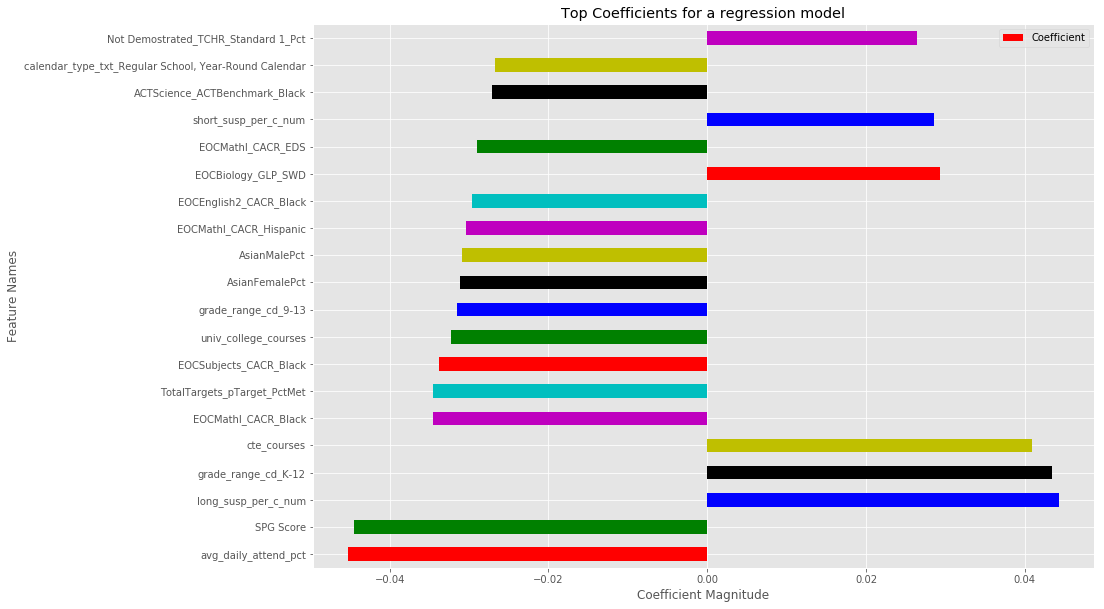

In [45]:
plt.style.use('ggplot')
Importances=predicted_data[0:20]
wt_plt_df = predicted_data.head(10)


ax = Importances.plot(kind='barh', color='rgbkymc', figsize=(14,10))


ax.set_title("Top Coefficients for a regression model")
ax.set_xlabel("Coefficient Magnitude")
ax.set_ylabel("Feature Names")
plt.show()

# Recursive Feature Elimination

In [46]:
model = GradientBoostingClassifier()
model.fit(X_crime_train, y_crime_train)
 
# make predictions for test data and evaluate
pred_y = model.predict(X_crime_test)
predictions = [round(value) for value in pred_y]
accuracy = roc_auc_score(y_crime_test, predictions)
print("RFC Accuracy: %.2f%%" % (accuracy * 100.0))
 
# fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)[::-1]

top_accuracy=0
accuracy_plot = []

for thresh in thresholds:
      
    # selecting features using threshold
    selection = SelectFromModel(model, threshold=thresh,prefit=True)
    select_train_X = selection.transform(X_crime_train)

    # training model
    selection_model = GradientBoostingClassifier(random_state=123,
                                                 max_depth=5, n_estimators=100)
    selection_model.fit(select_train_X, y_crime_train)
    
    # evaluating model
    select_test_x = selection.transform(X_crime_test)
    pred_y = selection_model.predict(select_test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = roc_auc_score(y_crime_test, predictions)
    #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_x.shape[1], accuracy*100.0))
    if accuracy > top_accuracy:
        top_accuracy = accuracy
    if thresh > 0.000:
        accuracy_plot.append(accuracy)
print(round(top_accuracy,5))

RFC Accuracy: 69.48%
0.73576


As shown in the line chart below, The optimal number of features is around 90 features that result in creating the model with more than 74% of accuracy. 
Using only the top 90 features give us a less complex model along with the maximum accuracy.

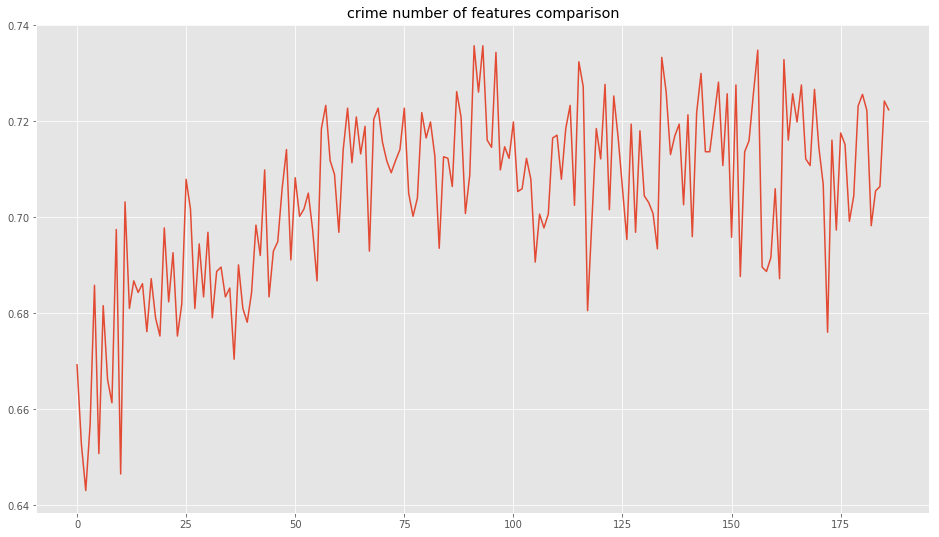

In [47]:
plt.figure(figsize=(16,9));
plt.plot(accuracy_plot);
plt.title('crime number of features comparison')
plt.show()


# Reduced scope model

In [48]:
list_of_keywords=['LEP','EDS','[Ww]hite','[Mm]ale','[Pp]acific[Ii]sland','[Aa]sian','[Hh]ispanic',
                  '[Rr]ace','[Bb]lack','[Mm]inority','[Tw]wo[Oo]r[Mm]ore','[Ii]ndian','[Ww]hite']

X_crime_reduced = X_crime[X_crime.columns.drop(list(X_crime.filter(regex='|'.join(list_of_keywords))))]
X_crime_reduced_train, X_crime_reduced_test, y_crime_reduced_train, y_crime_reduced_test = train_test_split(X_crime_reduced, y_crime, test_size=.2)

Based on the contributing features to the model we wanted to remove any items that could influence policy items that could be biased against a protected class, including sex and race, for the high schools in the schools specified in these North Carolina models. We wanted to remove any indicators that could possibly indicate the race of and makeup of the student body so as to not disadvantage any group of students with any recommendations for policy changes.

# Reduced method using Gradient Boost method

In [49]:
pipe.set_params(**crime_GradientBoost_model.best_params_)
pipe.fit(X_crime_reduced_train, y_crime_reduced_train)

y_crime_reduced_GradBoost_prob = pipe.predict_proba(X_crime_reduced_test)

print(round(roc_auc_score(y_crime_reduced_test, y_crime_reduced_GradBoost_prob[:,1]),5))

0.72931


In [50]:
coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_reduced_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:10])

The top 10 features that influence SPG Grade are the following


,Influence
avg_daily_attend_pct,0.084132
long_susp_per_c_num,0.075296
SPG Score,0.066424
Biology Score,0.064791
short_susp_per_c_num,0.064636
cte_courses,0.054503
stud_internet_comp_num,0.054246
grade_range_cd_K-12,0.040084
GraduationRate_5yr_All,0.032358
EOCBiology_CACR_SWD,0.028906


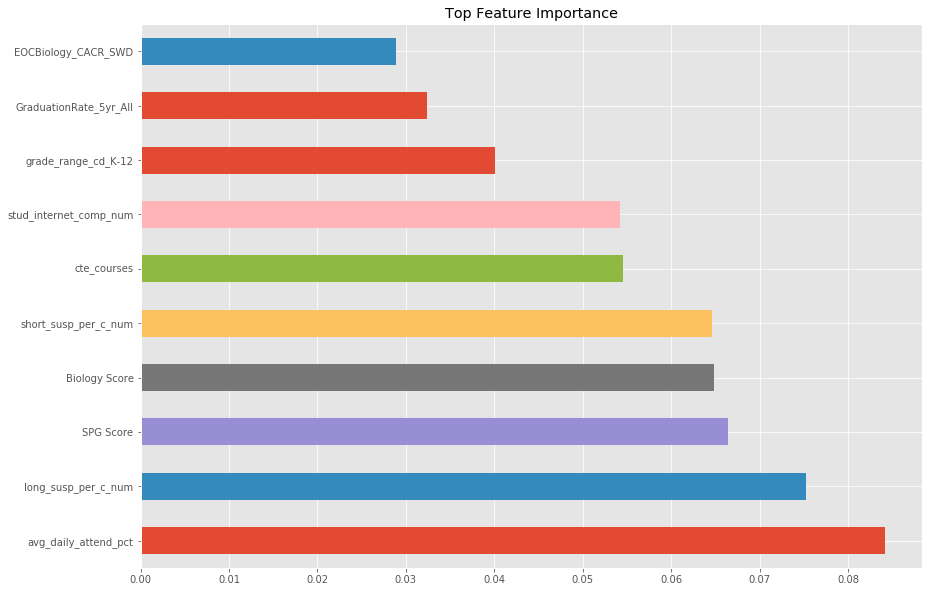

In [51]:
feat_importances = pd.Series(pipe.steps[2][1].feature_importances_, index=X_crime_reduced_train.columns)
feat_importances = feat_importances.nlargest(10)

ax = feat_importances.plot(kind='barh', figsize=(14,10))

ax.set_title("Top Feature Importance");

In [52]:
pipe.set_params(**crime_LogicReg_model.best_params_)
pipe.fit(X_crime_reduced_train, y_crime_reduced_train)

y_crime_LogReg_reduced_prob = pipe.predict_proba(X_crime_reduced_test)

print(round(roc_auc_score(y_crime_reduced_test, y_crime_LogReg_reduced_prob[:,1]),5))

0.7156


In [53]:
clf = pipe.steps[2][1]

abs_coef = np.asarray([abs(x) for x in clf.coef_ ])
mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_reduced_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 

predicted_data = pd.DataFrame({'Coefficient':clf.coef_[0],'abs_Influence':abs_coef[0]},index=new_features )
print("The top 10 features that influence improved crime rates for a school are the following")
predicted_data = predicted_data.sort_values(by='abs_Influence', ascending=False).drop('abs_Influence',axis=1,)
display(predicted_data[0:15])

The top 10 features that influence improved crime rates for a school are the following


,Coefficient
SPG Score,0.078408
avg_daily_attend_pct,0.064646
long_susp_per_c_num,-0.062802
cte_courses,-0.061445
univ_college_courses,0.051917
ACTMath_ACTBenchmark_All,0.049617
EOCSubjects_CACR_All,0.047580
GraduationRate_4yr_SWD,-0.045483
grade_range_cd_K-12,-0.045405
TotalTargets_pTarget_PctMet,0.045283


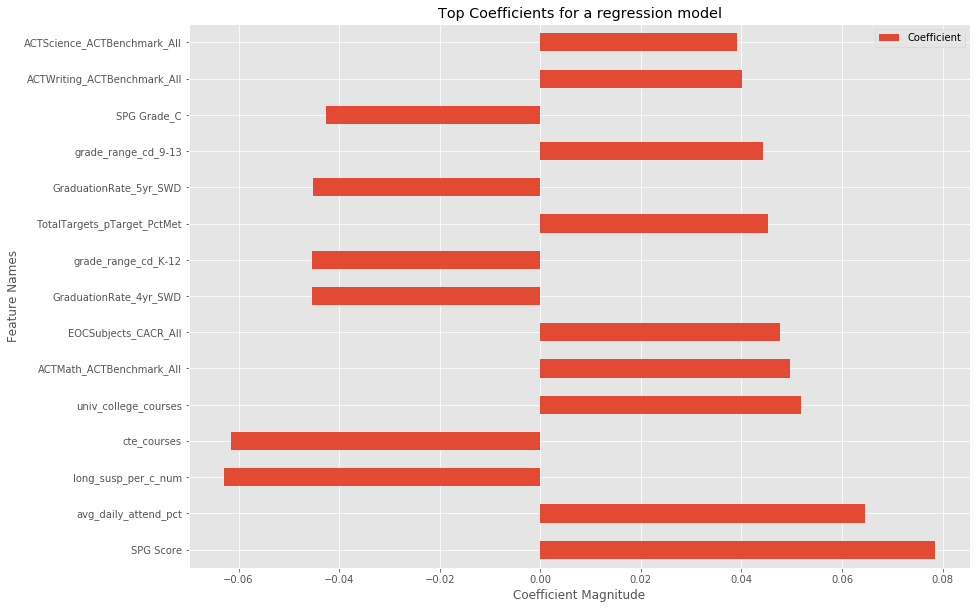

In [54]:
plt.style.use('ggplot')
Importances=predicted_data[0:15]
wt_plt_df = predicted_data.head(10)


ax = Importances.plot(kind='barh', figsize=(14,10))


ax.set_title("Top Coefficients for a regression model")
ax.set_xlabel("Coefficient Magnitude")
ax.set_ylabel("Feature Names")
plt.show()

# Deployment
5 points - How useful is yolur model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

# Exceptional Work
10 points - You have free reign to provide additional modeling. 
One idea: grid search parameters in a parallelized fashion and visualize the 
performances across attributes. Which parameters are most signiﬁcant for making a 
good model for each classiﬁcation algorithm?

# Reference

Explanation of ROC curves and AUC - https://www.dataschool.io/roc-curves-and-auc-explained/

Feature importance for Gradient Boosting - https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Getting feature importance with Bagging - https://stackoverflow.com/questions/44333573/feature-importances-bagging-scikit-learn